In [1]:
epochs, batch, lr = 100, 32, 1e-4
num_clients, in_channels, num_classes = 6, 1, 10
Dataset, Model, Prefix = 'MNIST', 'CNN_3', 'Attack'
Gdrive = '/content/drive/MyDrive/ColabNotebooks/SplitLearning3'
import torch; torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os; os.chdir(Gdrive)
%run library/Dataset.ipynb
%run library/Network.ipynb
%run library/Training.ipynb
from torchsummary import summary

In [4]:
!pip install pytorch-msssim
from pytorch_msssim import ssim, SSIM

In [5]:
def reconstruct(decoders):
  image = next(iter(DataLoader(testset)))[0]
  plt.imshow(transforms.ToPILImage()(image[0]))
  plt.figure(figsize=(32,8))
  for i in range(num_clients):
    plt.subplot(1, num_clients, i+1)
    with torch.no_grad():
      network.clients[i].eval(), decoders[i].eval()
      output = decoders[i](network.clients[i](image.cuda()))
    plt.imshow(transforms.ToPILImage()(output.cpu()[0]))
    plt.title(f'{ssim(image, output.cpu(), 1.0)}')

#Fashion

In [6]:
dataset, testset = loadDataset('Fashion')

In [7]:
clients = torch.ones((num_clients,))
clients = ratio_split(dataset, clients / clients.sum())

In [8]:
class Decoder(Autodecoder):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 3, 1, 1)
    )
  def forward(self, x):
    return self.model(x)

In [9]:
network = train_splitnn(clients, (testset, 1, 10), 'private', 50, 'VGG_7')

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

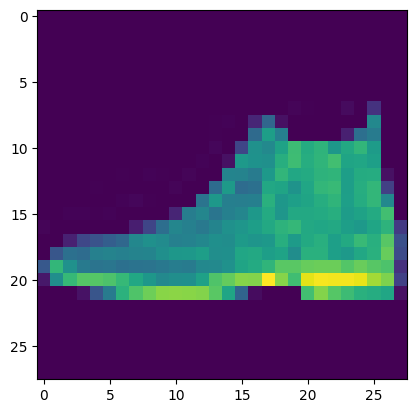

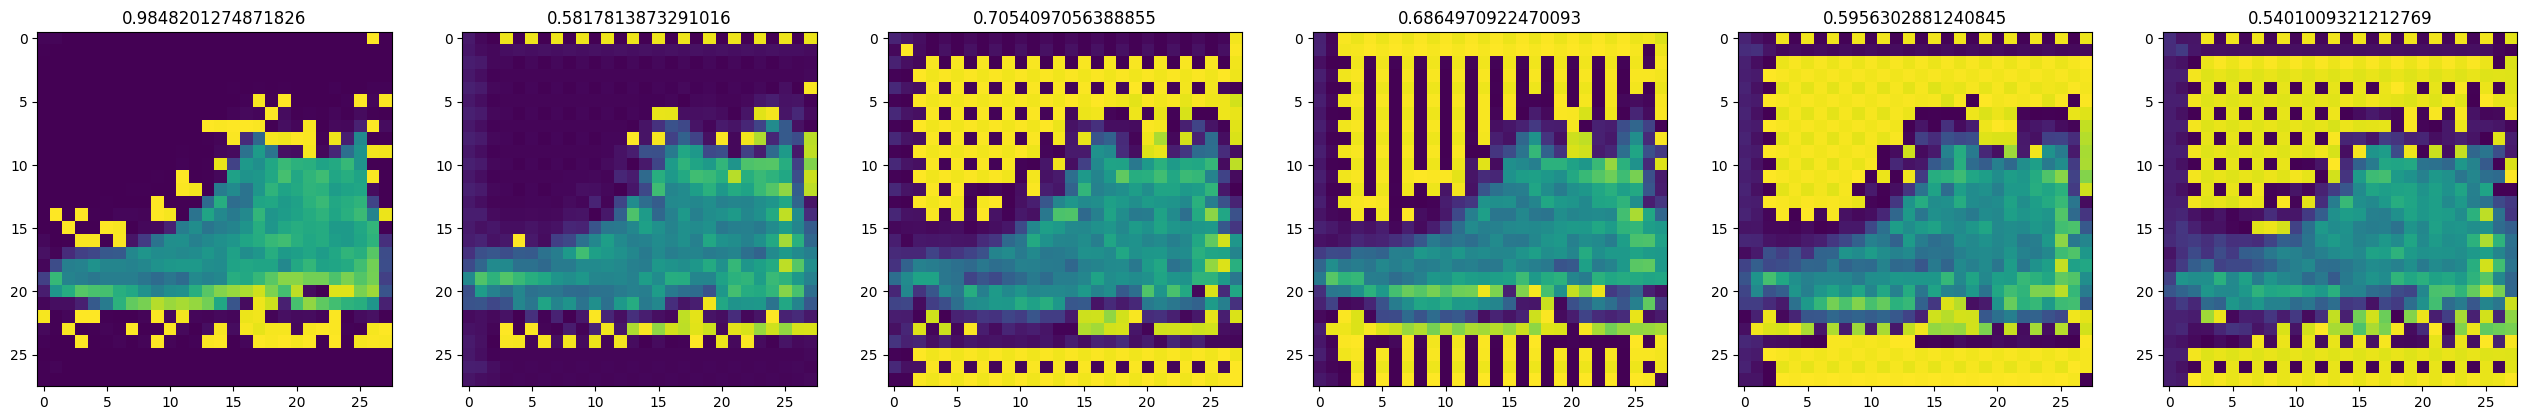

In [10]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

In [12]:
similarities = [0 for i in range(num_clients)]
for images, _ in tqdm(network.server.loader):
    for i, client in enumerate(network.clients):
        client.eval(), decoder.eval()
        output = decoder(client(images))
        similarities[i] += ssim(images, output, 1.0).item()
for i in range(num_clients):
    print('Client', i, similarities[i] / len(network.server.loader))

  0%|          | 0/157 [00:00<?, ?it/s]

Client 0 0.9735182417426139
Client 1 0.5478400147644578
Client 2 0.673746001188922
Client 3 0.5943177251299475
Client 4 0.5173693109469809
Client 5 0.5215204644734692


In [13]:
class Decoder2(Autodecoder):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.LeakyReLU(.2),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1), nn.BatchNorm2d(16), nn.LeakyReLU(.2),
            #nn.Conv2d(16, 16, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 3, 1, 1), nn.BatchNorm2d(16), nn.LeakyReLU(.2),
            nn.ConvTranspose2d(16, 1, 3, 1, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

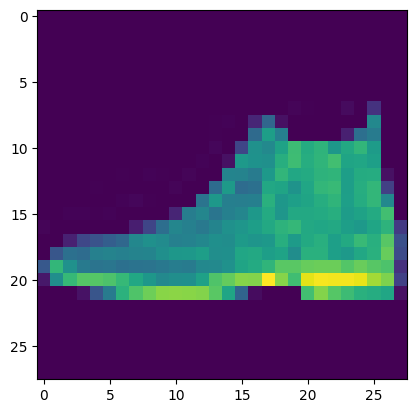

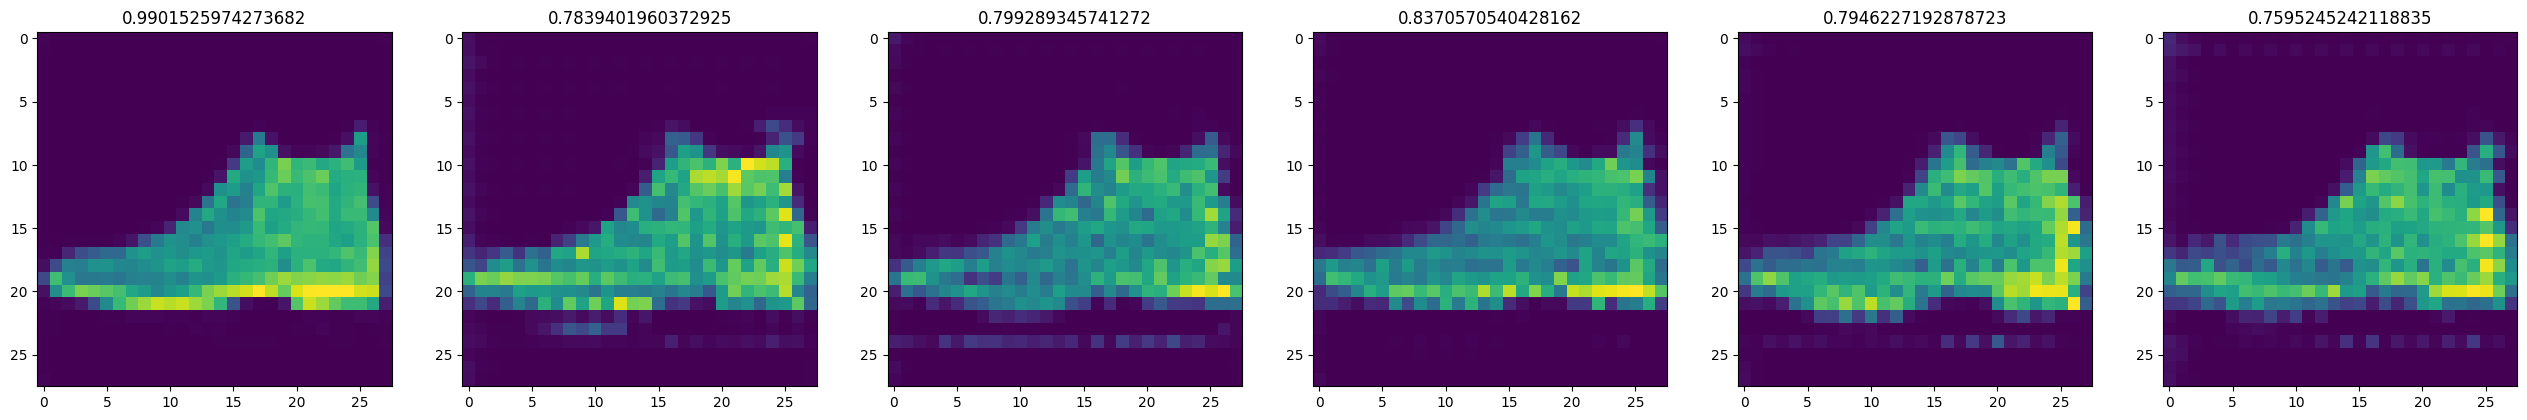

In [14]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

In [15]:
similarities = [0 for i in range(num_clients)]
for images, _ in tqdm(network.server.loader):
    for i, client in enumerate(network.clients):
        client.eval(), decoder.eval()
        output = decoder(client(images))
        similarities[i] += ssim(images, output, 1.0).item()
for i in range(num_clients):
    print('Client', i, similarities[i] / len(network.server.loader))

  0%|          | 0/157 [00:00<?, ?it/s]

Client 0 0.9837793108004673
Client 1 0.6704479843188244
Client 2 0.7375144791451229
Client 3 0.6957343718048873
Client 4 0.6504321515939797
Client 5 0.6514938151001171
